In [11]:
# ------------------------- Data Loading and Preparation ---------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tabulate import tabulate

# Load the dataset
file_path = "C:/Users/Administrator/Desktop/Project/project_Fraud_Detection_Transactions\synthetic_fraud_dataset.csv"
data = pd.read_csv(file_path)
# Extract new time features
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data['Transaction_Month'] = data['Timestamp'].dt.month
data['Transaction_Week'] = data['Timestamp'].dt.isocalendar().week
data['Day_of_Week'] = data['Timestamp'].dt.day_name()         # e.g., 'Monday'
data['Hour_of_Day'] = data['Timestamp'].dt.hour

# ----------------------- Quick EDA ---------------------------------
# Quick overview of key details
total_transactions = len(data)
fraud_cases = data['Fraud_Label'].sum()
fraud_percentage = (fraud_cases / total_transactions) * 100

# Fraud distribution by Location
fraud_by_location = data.groupby('Location')['Fraud_Label'].agg(
    Total_Fraud='sum', Total_Transactions='count'
)
fraud_by_location['Fraud_Percentage'] = (
    fraud_by_location['Total_Fraud'] / fraud_by_location['Total_Transactions'] * 100
)
fraud_by_location = fraud_by_location.sort_values('Fraud_Percentage', ascending=False)

# Time-based analysis
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Hour'] = data['Timestamp'].dt.hour
data['Month'] = data['Timestamp'].dt.month
data['Day_of_Week'] = data['Timestamp'].dt.day_name()

fraud_by_hour = data.groupby('Hour')['Fraud_Label'].sum().sort_values(ascending=False)
fraud_by_month = data.groupby('Month')['Fraud_Label'].sum().sort_values(ascending=False)

# Transaction Amount Analysis
avg_transaction_amount_fraud = data[data['Fraud_Label'] == 1]['Transaction_Amount'].mean()
avg_transaction_amount_non_fraud = data[data['Fraud_Label'] == 0]['Transaction_Amount'].mean()

# Risk Score Analysis
avg_risk_score_fraud = data[data['Fraud_Label'] == 1]['Risk_Score'].mean()
avg_risk_score_non_fraud = data[data['Fraud_Label'] == 0]['Risk_Score'].mean()

# Device Analysis
fraud_by_device = data.groupby('Device_Type')['Fraud_Label'].sum()

# ------------------------- Data Overview ---------------------------
print("DATA INFORMATION:")
print("-" * 50)
data.info()  # This prints the dataframe info directly to the console

print("\nDATA STATISTICAL SUMMARY:")
print("-" * 50)
print(data.describe())
print()

# ------------- Display Insights for fraud distribution, Time-based, Transaction Amount, Risk Score, Devide---------------------------------
print("Summary of Transaction Dataset")
print("=" * 50)
print(f"Total Transactions       : {total_transactions}")
print(f"Total Fraud Cases        : {fraud_cases}")
print(f"Overall Fraud Percentage : {fraud_percentage:.2f}%")
print()

print("Fraud Distribution by Location:")
print(tabulate(fraud_by_location, headers="keys", tablefmt="psql"))
print()

print("Fraud Trends by Hour:")
print(tabulate(fraud_by_hour.reset_index(), headers=["Hour", "Fraud Cases"], tablefmt="psql"))
print()

print("Fraud Trends by Month:")
print(tabulate(fraud_by_month.reset_index(), headers=["Month", "Fraud Cases"], tablefmt="psql"))
print()

print("Transaction Amount Analysis:")
print(f" - Avg Transaction Amount (Fraud)    : {avg_transaction_amount_fraud:.2f}")
print(f" - Avg Transaction Amount (Non-Fraud): {avg_transaction_amount_non_fraud:.2f}")
print()

print("Risk Score Analysis:")
print(f" - Avg Risk Score (Fraud)    : {avg_risk_score_fraud:.2f}")
print(f" - Avg Risk Score (Non-Fraud): {avg_risk_score_non_fraud:.2f}")
print()




DATA INFORMATION:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Transaction_ID                50000 non-null  object        
 1   User_ID                       50000 non-null  object        
 2   Transaction_Amount            50000 non-null  float64       
 3   Transaction_Type              50000 non-null  object        
 4   Timestamp                     50000 non-null  datetime64[ns]
 5   Account_Balance               50000 non-null  float64       
 6   Device_Type                   50000 non-null  object        
 7   Location                      50000 non-null  object        
 8   Merchant_Category             50000 non-null  object        
 9   IP_Address_Flag               50000 non-null  int64         
 10  Previous_Fraudulent_Activ

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18932\4276449560.py:9: SyntaxWarning: invalid escape sequence '\s'
  file_path = "C:/Users/Administrator/Desktop/Project/project_Fraud_Detection_Transactions\synthetic_fraud_dataset.csv"


   Transaction_Amount  Avg_Transaction_Amount_7d  Transaction_amount_ratio  \
0               39.79                     437.63                  0.090922   
1                1.19                     478.76                  0.002486   
2               28.96                      50.01                  0.579084   
3              254.32                     182.48                  1.393687   
4               31.28                     328.69                  0.095166   

   Failed_Transaction_Count_7d  Daily_Transaction_Count  Failed_txn_rate  \
0                            3                        7         0.428571   
1                            4                       13         0.307692   
2                            4                       14         0.285714   
3                            4                        8         0.500000   
4                            4                       14         0.285714   

   Account_Balance  Flag_large_sudden_withdrawal Device_Type  IP_Address_F

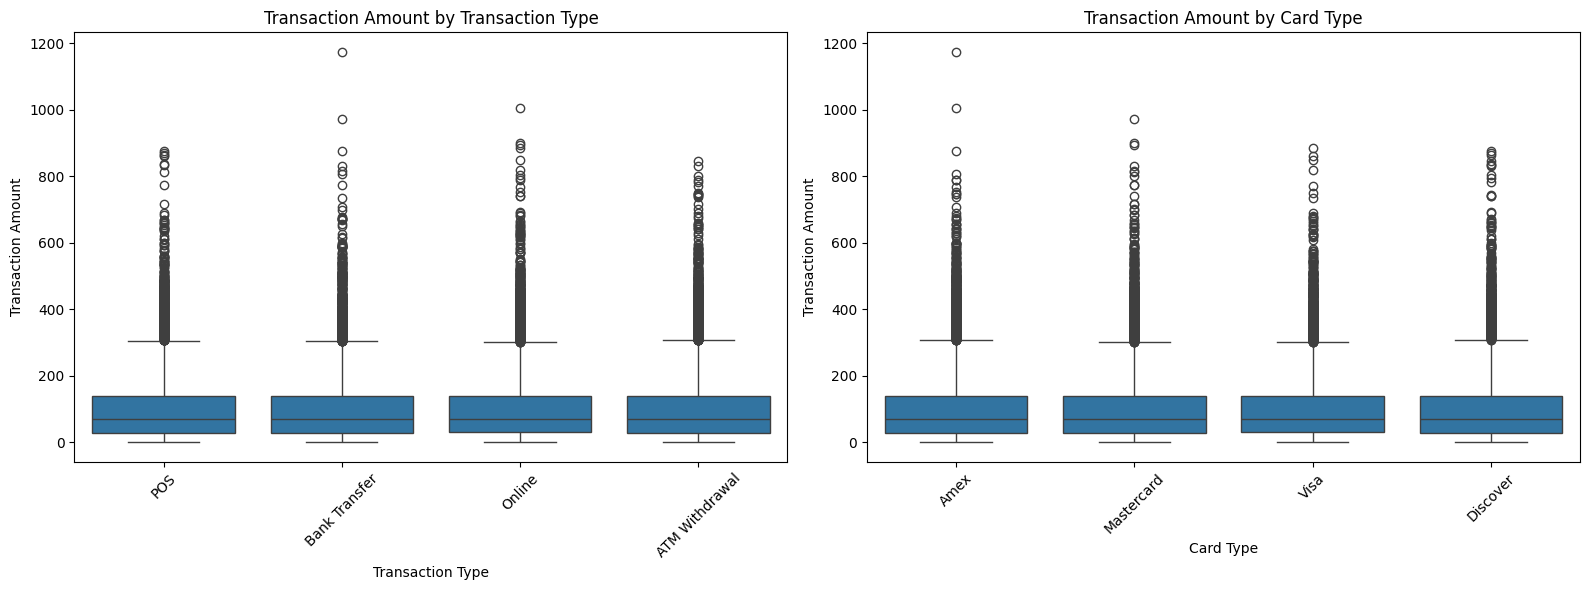

C:\Users\Administrator\AppData\Local\Temp\ipykernel_19232\1890992177.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Device_Type', y='Avg_Transaction_Amount_7d', data=avg_txn_7d_by_device, palette='Blues_d')


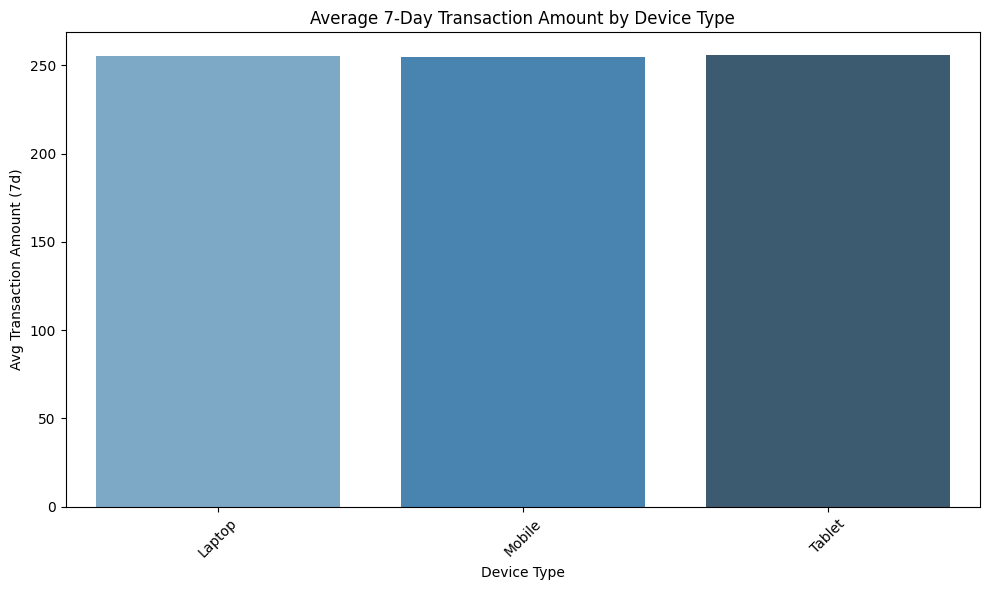

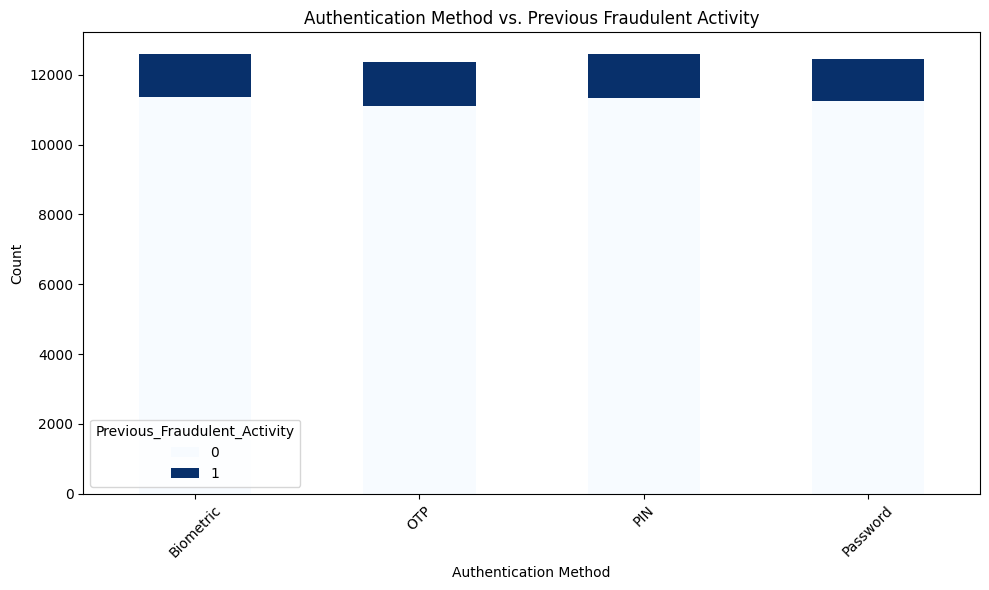

In [20]:
# ------------------------- Create New Insights for Feature Engineering Ideas---------------------------
# 1. Transaction Amount Ratio: current transaction compared to the 7-day average
data['Transaction_amount_ratio'] = data['Transaction_Amount'] / data['Avg_Transaction_Amount_7d']

# 2. Failed Transaction Rate: failed transaction count over daily transaction count
data['Failed_txn_rate'] = data['Failed_Transaction_Count_7d'] / data['Daily_Transaction_Count']

# 3. Flag large, sudden withdrawals:
#    For this example, we flag a transaction as suspicious if the transaction amount is more than twice the 7-day average 
#    (i.e., Transaction_amount_ratio > 2) and the account balance is lower than the transaction amount.
data['Flag_large_sudden_withdrawal'] = np.where(
    (data['Transaction_amount_ratio'] > 2) & (data['Account_Balance'] < data['Transaction_Amount']),
    1, 0
)

# 4. Combine device/IP behavior:
#    Mark as suspicious if the Device_Type is "new" (case-insensitive) and IP_Address_Flag equals 1.
data['Flag_suspicious_device_ip'] = np.where(
    (data['Device_Type'].str.lower() == 'new') & (data['IP_Address_Flag'] == 1),
    1, 0
)

# 5. Time-based features:
#    Extract hour of day, day of week, and flag weekend transactions.
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Hour'] = data['Timestamp'].dt.hour
data['Day_of_Week'] = data['Timestamp'].dt.day_name()
data['Is_Weekend'] = np.where(data['Day_of_Week'].isin(['Saturday', 'Sunday']), 1, 0)

# ------------------------- Display New Features ---------------------------
# Show a few rows of the newly created columns for verification
print(data[[
    'Transaction_Amount', 'Avg_Transaction_Amount_7d', 'Transaction_amount_ratio',
    'Failed_Transaction_Count_7d', 'Daily_Transaction_Count', 'Failed_txn_rate',
    'Account_Balance', 'Flag_large_sudden_withdrawal',
    'Device_Type', 'IP_Address_Flag', 'Flag_suspicious_device_ip',
    'Timestamp', 'Hour', 'Day_of_Week', 'Is_Weekend'
]].head())

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------- 1. Box Plots -------------------
# Box plot of Transaction_Amount by Transaction_Type and Card_Type

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot for Transaction_Type
sns.boxplot(x='Transaction_Type', y='Transaction_Amount', data=data, ax=axes[0])
axes[0].set_title('Transaction Amount by Transaction Type')
axes[0].set_xlabel('Transaction Type')
axes[0].set_ylabel('Transaction Amount')
axes[0].tick_params(axis='x', rotation=45)

# Box plot for Card_Type
sns.boxplot(x='Card_Type', y='Transaction_Amount', data=data, ax=axes[1])
axes[1].set_title('Transaction Amount by Card Type')
axes[1].set_xlabel('Card Type')
axes[1].set_ylabel('Transaction Amount')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# ------------------- 2. Bar Plot -------------------
# Bar plot: Average of Avg_Transaction_Amount_7d by Device_Type
# First, group the data by Device_Type and compute the mean
avg_txn_7d_by_device = data.groupby('Device_Type')['Avg_Transaction_Amount_7d'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Device_Type', y='Avg_Transaction_Amount_7d', data=avg_txn_7d_by_device, palette='Blues_d')
plt.title("Average 7-Day Transaction Amount by Device Type")
plt.xlabel("Device Type")
plt.ylabel("Avg Transaction Amount (7d)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ------------------- 3. Stacked Bar Chart -------------------
# Stacked bar: Authentication_Method vs. Previous_Fraudulent_Activity
# Create a crosstab to count occurrences
auth_prev_fraud = pd.crosstab(data['Authentication_Method'], data['Previous_Fraudulent_Activity'])

# Plot the stacked bar chart
auth_prev_fraud.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Blues')
plt.title("Authentication Method vs. Previous Fraudulent Activity")
plt.xlabel("Authentication Method")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


----------------Data Source Overview-----------------
Total number of unique users in the dataset: 8963
Total fraud loss transaction amount in the dataset: 1601617.65
Avg fraud loss transaction amount per transaction in the dataset: 99.68367772452854
Median fraud loss transaction amount per transaction in the dataset: 70.12
----------------Month Analysis-----------------
Avg fraud loss transaction count per Month in the dataset: 1338.9166666666667
Min fraud loss transaction count Month in the dataset: 1246
Max fraud loss transaction count Month in the dataset: 1434
----------------Week Analysis-----------------
Avg transaction count Weekend in the dataset: 2354.5
Avg transaction count Workday in the dataset: 2278.75
Avg transaction count Weekend compared to Workday have an average increase of: 3.32%
Transaction count for Saturday in the dataset: 2330
Transaction count for Sunday in the dataset: 2379
----------------Hour Analysis-----------------
Top 3 hours with highest weekend fraud t

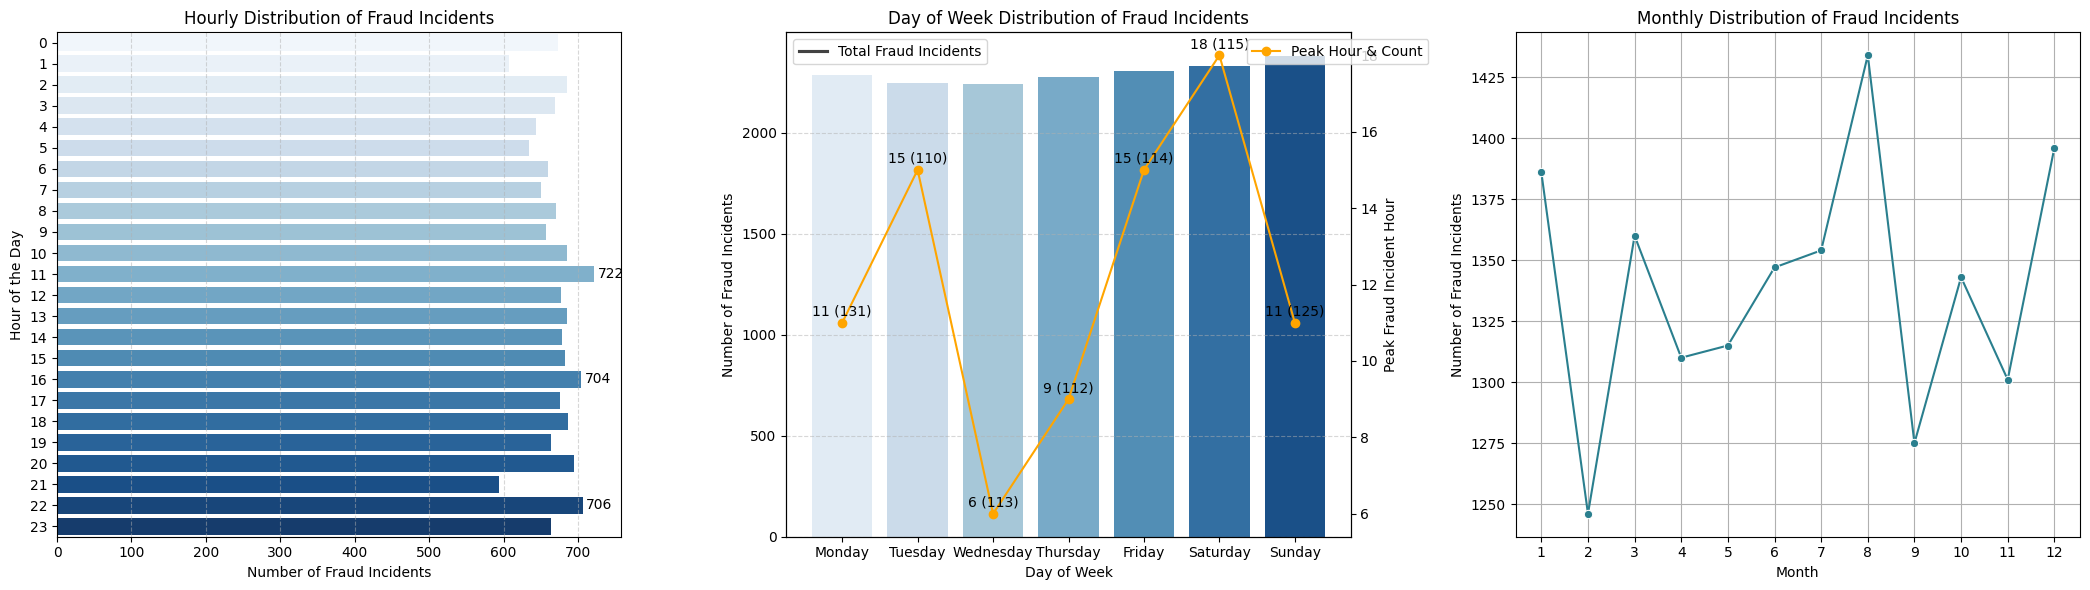

In [ ]:
# ---------------------Basic EDA about this datasets (including the Time-Based Analysis)----------------------------------------
# ------------------Excutive Summary------------------------------------------------
fraud_data = data[data['Fraud_Label'] == 1] # all fraud transaction data
no_fraud_data = data[data['Fraud_Label'] == 0]
weekend_fraud_data = data[(data['Fraud_Label'] == 1) & (data['Day_of_Week'].isin(['Saturday', 'Sunday']))]
workday_fraud_data = data[(data['Fraud_Label'] == 1) & (data['Day_of_Week'].isin(['Monday', 'Tuesday', 'Wednsday', 'Thursday', 'Friday']))]
# Identify Unique Users
unique_user_count = data['User_ID'].nunique()
print("----------------Data Source Overview-----------------")
print(f"Total number of unique users in the dataset: {unique_user_count}")
# Identify the total loss for these dataset due to the fraud
total_fraud_loss = sum(fraud_data['Transaction_Amount'])
print(f"Total fraud loss transaction amount in the dataset: {total_fraud_loss}")
fraud_transaction_count = len(fraud_data)
avg_loss_case = total_fraud_loss/fraud_transaction_count
print(f"Avg fraud loss transaction amount per transaction in the dataset: {avg_loss_case}")
median_loss_case = fraud_data['Transaction_Amount'].median()
print(f"Median fraud loss transaction amount per transaction in the dataset: {median_loss_case}")
# --------------------Time Series analysis with data & charts ------------------------
# Avg fraud count per month
print("----------------Month Analysis-----------------")
avg_fraud_count_permonth = fraud_data['Month'].value_counts().mean()
print(f"Avg fraud loss transaction count per Month in the dataset: {avg_fraud_count_permonth}")
min_fraud_count_month = fraud_data['Month'].value_counts().min()
print(f"Min fraud loss transaction count Month in the dataset: {min_fraud_count_month}")
max_fraud_count_month = fraud_data['Month'].value_counts().max()
print(f"Max fraud loss transaction count Month in the dataset: {max_fraud_count_month}")
print("----------------Week Analysis-----------------")
avg_weekend_count = fraud_data[fraud_data['Day_of_Week'].isin(['Saturday', 'Sunday'])]['Day_of_Week'].value_counts().mean()
print(f"Avg transaction count Weekend in the dataset: {avg_weekend_count}")
avg_Workday_count = fraud_data[fraud_data['Day_of_Week'].isin(['Monday', 'Tuesday', 'Wednsday', 'Thursday', 'Friday'])]['Day_of_Week'].value_counts().mean()
print(f"Avg transaction count Workday in the dataset: {avg_Workday_count}")
percentage_increase_weekday_to_weekend = (avg_weekend_count - avg_Workday_count)/avg_Workday_count * 100
print(f"Avg transaction count Weekend compared to Workday have an average increase of: {percentage_increase_weekday_to_weekend:.2f}%")
Sat_fraud_count = len(fraud_data[fraud_data['Day_of_Week'].isin(['Saturday'])])
print(f"Transaction count for Saturday in the dataset: {Sat_fraud_count}")
Sun_fraud_count = len(fraud_data[fraud_data['Day_of_Week'].isin(['Sunday'])])
print(f"Transaction count for Sunday in the dataset: {Sun_fraud_count}")
print("----------------Hour Analysis-----------------")
weekend_avg_per_hour = weekend_fraud_data.groupby(['Hour', 'Day_of_Week']).size().unstack(fill_value=0).mean(axis=1)
top_3_weekend_hours = weekend_avg_per_hour.nlargest(3)
print("Top 3 hours with highest weekend fraud transaction averages: " + ', '.join([f"{hour}: {count:.2f} avg counts" for hour, count in top_3_weekend_hours.items()]))
workday_avg_per_hour = workday_fraud_data.groupby(['Hour', 'Day_of_Week']).size().unstack(fill_value=0).mean(axis=1)
top_3_workday_hours = workday_avg_per_hour.nlargest(3)
print("Top 3 hours with highest workday fraud transaction averages: " +', '.join([f"{hour}: {count:.2f} avg counts" for hour, count in top_3_workday_hours.items()]))

# ------------------- User-Related Charts -------------------------------------------------------------------------------------------------------
# Setting color palettes
colors_1 = sns.color_palette("Blues", 24)
colors_2 = sns.color_palette("Blues", 7)
# Plotting - Combined Graph for Hourly and Weekly Fraud Distribution
plt.figure(figsize=(21, 6))
# ---------------- Hourly Fraud Distribution (Horizontal Bar Chart) ----------------
plt.subplot(1, 3, 1)
hourly_counts = fraud_data['Hour'].value_counts().sort_index()
# Fixed Warning: Added `hue` and `legend=False`
ax = sns.barplot(y=hourly_counts.index, x=hourly_counts.values, hue=hourly_counts.index, palette=colors_1, orient='h', legend=False)
plt.title('Hourly Distribution of Fraud Incidents')
plt.ylabel('Hour of the Day')
plt.xlabel('Number of Fraud Incidents')
plt.grid(axis='x', linestyle='--', alpha=0.5)
# Annotate the three highest values
top_hours = hourly_counts.nlargest(3)
for hour, count in zip(top_hours.index, top_hours.values):
    ax.text(count + 5, hour, str(count), va='center')
# ---------------- Day of Week Fraud Distribution ----------------
plt.subplot(1, 3, 2)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
Day_counts = fraud_data['Day_of_Week'].value_counts().reindex(day_order, fill_value=0)
# Fixed Warning: Added `hue` and `legend=False`
ax1 = sns.barplot(x=Day_counts.index, y=Day_counts.values, hue=Day_counts.index, palette=colors_2, legend=False)
plt.title('Day of Week Distribution of Fraud Incidents')
plt.xlabel('Day of Week')
plt.ylabel('Number of Fraud Incidents')
plt.grid(axis='y', linestyle='--', alpha=0.5)
# Identify peak hour and peak fraud count for each day
peak_hours = []
peak_counts = []
for day in day_order:
    data_day = fraud_data[fraud_data['Day_of_Week'] == day]
    if not data_day.empty:
        Hour_counts = data_day.groupby('Hour').size().sort_index()
        peak_hour = Hour_counts.idxmax()
        peak_value = Hour_counts.max()
        peak_hours.append(peak_hour)
        peak_counts.append(peak_value)
    else:
        peak_hours.append(None)
        peak_counts.append(0)
# Create a second y-axis for the peak hours
ax2 = ax1.twinx()
ax2.plot(day_order, peak_hours, color='orange', marker='o', label='Peak Hour')
ax2.set_ylabel('Peak Fraud Incident Hour')
# Annotate peak hour points with both hour and count
for i, (day, hour, count) in enumerate(zip(day_order, peak_hours, peak_counts)):
    if hour is not None:  # Avoids empty entries
        ax2.annotate(f"{hour} ({count})", (i, hour), textcoords="offset points", 
                     xytext=(0, 5), ha='center')
# Add legends
ax1.legend(['Total Fraud Incidents'], loc='upper left')
ax2.legend(['Peak Hour & Count'], loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
# ---------------- Monthly Fraud Distribution ----------------
plt.subplot(1, 3, 3)
monthly_fraud_counts = fraud_data['Month'].value_counts().sort_index()
ax3 = sns.lineplot(x=monthly_fraud_counts.index, y=monthly_fraud_counts.values, marker='o', color='#2A7F8E')
plt.title('Monthly Distribution of Fraud Incidents')
plt.xlabel('Month')
plt.ylabel('Number of Fraud Incidents')
plt.grid(True)
# Ensure all months are evenly displayed
plt.xticks(monthly_fraud_counts.index)
plt.tight_layout()
plt.show()

Location  User Num  Fraud User Num  Repeated Fraud User Num  Fraud Rate (%)  Repeated Fraud Rate (%)  User usual distance  fraud user distance  fraud transaction value
   Tokyo      6129            2776                      482           45.29                     7.86              2543.62              2535.22                330928.09
  London      6012            2692                      441           44.78                     7.34              2479.39              2464.84                321077.68
  Mumbai      6009            2662                      444           44.30                     7.39              2488.06              2497.00                311294.35
  Sydney      6003            2692                      449           44.84                     7.48              2493.74              2502.83                313112.40
New York      5983            2709                      462           45.28                     7.72              2489.86              2493.23                32

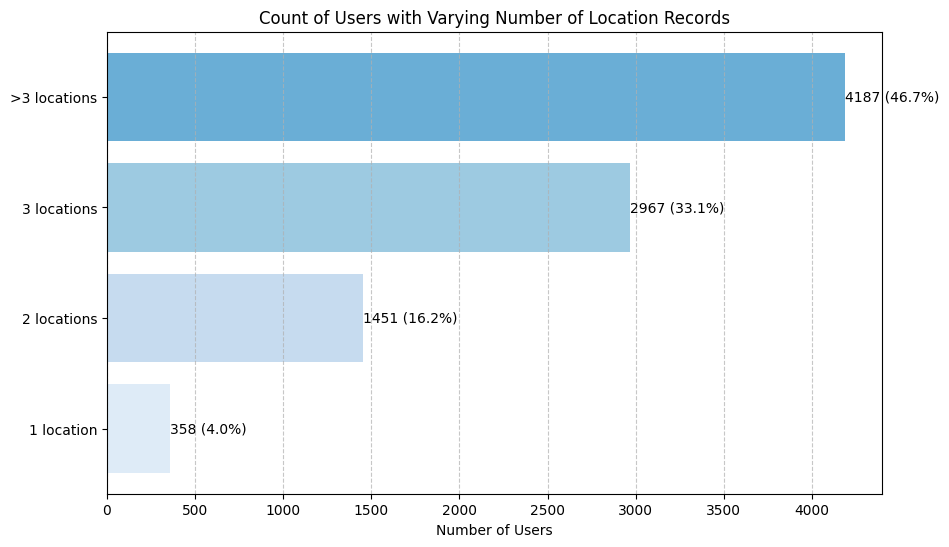

Total number of unique users in Tokyo: 6129
Total number of unique users in London: 6012
Total number of unique users in Mumbai: 6009
Total number of unique users in Sydney: 6003
Total number of unique users in New York: 5983

Total number of unique users in the entire dataset: 8963
Total number of unique fraud users in the dataset: 7482
Number of users with more than one fraudulent transaction: 4826

Average transaction distance for fraud users:2509.79
Average transaction distance for no fraud users:2498.08

Average transaction distance for users had fraud in Tokyo:2545.38
Average transaction distance for users had no fraud in Tokyo:2543.17
Average transaction distance for users had fraud in London:2458.16
Average transaction distance for users had no fraud in London:2489.55
Average transaction distance for users had fraud in Mumbai:2508.65
Average transaction distance for users had no fraud in Mumbai:2489.52
Average transaction distance for users had fraud in Sydney:2504.3
Average tr

In [13]:
# --------------------User-Related Analysis with data & charts ------------------------
# ------------------- User-Related Table -----------------------------------------------------------------------------------------------------------
grouped = data.groupby('Location')
# User count (unique users per location)
user_count = grouped['User_ID'].nunique()
# Fraud user count (unique fraud users per location)
fraud_user_count = data[data['Fraud_Label'] == 1].groupby('Location')['User_ID'].nunique()
# Repeated fraud user count (users with multiple fraud cases per location)
repeated_fraud_user_count = (
    data[data['Fraud_Label'] == 1]
    .groupby(['Location', 'User_ID'])
    .size()
    .reset_index(name='Fraud_Count')
    .query('Fraud_Count > 1')
    .groupby('Location')['User_ID']
    .nunique()
)
# User usual distance (average distance for all users)
user_usual_distance = grouped['Transaction_Distance'].mean().round(2)
# Fraud user distance (average distance for fraudulent transactions)
fraud_user_distance = (
    data[data['Fraud_Label'] == 1]
    .groupby('Location')['Transaction_Distance'].mean().round(2)
)
# Fraud transaction value (sum of fraudulent transaction amounts)
fraud_transaction_value = (
    data[data['Fraud_Label'] == 1]
    .groupby('Location')['Transaction_Amount'].sum().round(2)
)
# Summary for the User-Related Table
summary_table = pd.DataFrame({
    'User Num': user_count,
    'Fraud User Num': fraud_user_count,
    'Repeated Fraud User Num': repeated_fraud_user_count,
    'Fraud Rate (%)': (fraud_user_count/user_count * 100).round(2),
    'Repeated Fraud Rate (%)': (repeated_fraud_user_count/user_count * 100).round(2),
    'User usual distance': user_usual_distance,
    'fraud user distance': fraud_user_distance,
    'fraud transaction value': fraud_transaction_value
}).reset_index()
summary_table = summary_table.sort_values(by='User Num', ascending=False).reset_index(drop=True)
print(summary_table.to_string(index=False))
print()

# Count of how many user in this transaction dataset having more than one location records
user_location_counts = data.groupby('User_ID')['Location'].nunique()
users_with_one_locations = user_location_counts[user_location_counts == 1]
users_with_two_locations = user_location_counts[user_location_counts == 2]
users_with_three_locations = user_location_counts[user_location_counts == 3]
users_with_more_than_three_locations = user_location_counts[user_location_counts > 3]
num_with_one_users = users_with_one_locations.count()
num_with_two_users = users_with_two_locations.count()
num_with_three_users = users_with_three_locations.count()
num_with_more_than_three_users = users_with_more_than_three_locations.count()
print(f"Number of users with only one location: {num_with_one_users}")
print(f"Number of users with two location: {num_with_two_users}")
print(f"Number of users with three location: {num_with_three_users}")
print(f"Number of users with more than three location: {num_with_more_than_three_users}")
print()
# Bar chart showing the user location record relevant information
# Define the color palette as provided
colors_1 = sns.color_palette("Blues", 24)
colors_2 = sns.color_palette("Blues", 7)

# Prepare labels and counts for plotting
labels = ['1 location', '2 locations', '3 locations', '>3 locations']
counts = [num_with_one_users, num_with_two_users, num_with_three_users, num_with_more_than_three_users]

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, counts, color=colors_2[:len(labels)])

# Add the count and percentage on each bar
total_users = sum(counts)
for bar, count in zip(bars, counts):
    width = bar.get_width()
    percentage = (count / total_users) * 100
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{count} ({percentage:.1f}%)', 
             va='center', fontsize=10)

plt.xlabel('Number of Users')
plt.title('Count of Users with Varying Number of Location Records')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# --------------------------- Table data analysis and verify --------------------------------------
# Count of unique users in Tokyo, London, Mumbai, Sydney, New York
tokyo_num = data[data['Location'] == 'Tokyo'].groupby('User_ID')['User_ID'].count()
print(f"Total number of unique users in Tokyo: {len(tokyo_num)}")
london_num = data[data['Location'] == 'London'].groupby('User_ID')['User_ID'].count()
print(f"Total number of unique users in London: {len(london_num)}")
mumbai_num = data[data['Location'] == 'Mumbai'].groupby('User_ID')['User_ID'].count()
print(f"Total number of unique users in Mumbai: {len(mumbai_num)}")
sydney_num = data[data['Location'] == 'Sydney'].groupby('User_ID')['User_ID'].count()
print(f"Total number of unique users in Sydney: {len(sydney_num)}")
new_york_num = data[data['Location'] == 'New York'].groupby('User_ID')['User_ID'].count()
print(f"Total number of unique users in New York: {len(new_york_num)}")
print()

# Count of total unique users across all locations
all_data_num = data.groupby('User_ID')['User_ID'].count()
print(f"Total number of unique users in the entire dataset: {len(all_data_num)}")
# Count of unique fraud users
fraud_user_all_num = fraud_data.groupby('User_ID')['User_ID'].count()
print(f"Total number of unique fraud users in the dataset: {len(fraud_user_all_num)}")
# Count of users with more than one fraudulent transaction
print(f"Number of users with more than one fraudulent transaction: {len(fraud_user_all_num[fraud_user_all_num > 1])}")
print()

# Based on different fraud and no fraud data to analysis the avg user distance
# Correct calculation for average Transaction_Distance for fraud users
fraud_data_avg_dis = fraud_data.groupby('User_ID')['Transaction_Distance'].mean().mean().round(2)
print(f"Average transaction distance for fraud users:{fraud_data_avg_dis}")
# Correct calculation for average Transaction_Distance for non-fraud users
non_fraud_data_avg_dis = no_fraud_data.groupby('User_ID')['Transaction_Distance'].mean().mean().round(2)
print(f"Average transaction distance for no fraud users:{non_fraud_data_avg_dis}")
print()

# Avg user distance having fraud recrod and no fraud record for Tokyo, London, Mumbai, Sydney, New York
tokyo_fraud_dis = fraud_data[fraud_data['Location'] == 'Tokyo'].groupby('User_ID')['Transaction_Distance'].mean().mean().round(2)
print(f"Average transaction distance for users had fraud in Tokyo:{tokyo_fraud_dis}")
tokyo_no_fraud_dis = no_fraud_data[no_fraud_data['Location'] == 'Tokyo'].groupby('User_ID')['Transaction_Distance'].mean().mean().round(2)
print(f"Average transaction distance for users had no fraud in Tokyo:{tokyo_no_fraud_dis}")
London_fraud_dis = fraud_data[fraud_data['Location'] == 'London'].groupby('User_ID')['Transaction_Distance'].mean().mean().round(2)
print(f"Average transaction distance for users had fraud in London:{London_fraud_dis}")
London_no_fraud_dis = no_fraud_data[no_fraud_data['Location'] == 'London'].groupby('User_ID')['Transaction_Distance'].mean().mean().round(2)
print(f"Average transaction distance for users had no fraud in London:{London_no_fraud_dis}")
Mumbai_fraud_dis = fraud_data[fraud_data['Location'] == 'Mumbai'].groupby('User_ID')['Transaction_Distance'].mean().mean().round(2)
print(f"Average transaction distance for users had fraud in Mumbai:{Mumbai_fraud_dis}")
Mumbai_no_fraud_dis = no_fraud_data[no_fraud_data['Location'] == 'Mumbai'].groupby('User_ID')['Transaction_Distance'].mean().mean().round(2)
print(f"Average transaction distance for users had no fraud in Mumbai:{Mumbai_no_fraud_dis}")
Sydney_fraud_dis = fraud_data[fraud_data['Location'] == 'Sydney'].groupby('User_ID')['Transaction_Distance'].mean().mean().round(2)
print(f"Average transaction distance for users had fraud in Sydney:{Sydney_fraud_dis}")
Sydney_no_fraud_dis = no_fraud_data[no_fraud_data['Location'] == 'Sydney'].groupby('User_ID')['Transaction_Distance'].mean().mean().round(2)
print(f"Average transaction distance for users had no fraud in Sydney:{Sydney_no_fraud_dis}")
new_york_fraud_dis = fraud_data[fraud_data['Location'] == 'New York'].groupby('User_ID')['Transaction_Distance'].mean().mean().round(2)
print(f"Average transaction distance for users had fraud in New York:{new_york_fraud_dis}")
new_york_no_fraud_dis = no_fraud_data[no_fraud_data['Location'] == 'New York'].groupby('User_ID')['Transaction_Distance'].mean().mean().round(2)
print(f"Average transaction distance for users had no fraud in New York:{new_york_no_fraud_dis}")

In [6]:
#Column name for this dataset 
data.columns

Index(['Transaction_ID', 'User_ID', 'Transaction_Amount', 'Transaction_Type',
       'Timestamp', 'Account_Balance', 'Device_Type', 'Location',
       'Merchant_Category', 'IP_Address_Flag', 'Previous_Fraudulent_Activity',
       'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d',
       'Failed_Transaction_Count_7d', 'Card_Type', 'Card_Age',
       'Transaction_Distance', 'Authentication_Method', 'Risk_Score',
       'Is_Weekend', 'Fraud_Label', 'Hour', 'Month', 'Day_of_Week'],
      dtype='object')

Average transaction value for this data is 99.41
Average fraud transaction value for this data is 99.68
Average normal transaction value is 99.28
-------------------Fraud Device type analysis
Fraud Device Distribution is Tablet: 5464 (34.01%); Mobile: 5305 (33.02%); Laptop: 5298 (32.97%)
Fraud Percentage by Device Type: Tablet: 32.56%, Mobile: 31.88%, Laptop: 31.95%
-------------------Fraud Transaction type analysis
Fraud trasnction type Distribution is ATM Withdrawal: 4046 (25.18%); Online: 4031 (25.09%); Bank Transfer: 3995 (24.86%); POS: 3995 (24.86%)
Fraud Percentage by transaction Type: ATM Withdrawal: 32.49%, Bank Transfer: 32.08%, Online: 32.13%, POS: 31.84%
-------------------Fraud Merchant Category analysis
Fraud Merchant Category Distribution is Restaurants: 3255 (20.26%); Travel: 3235 (20.13%); Groceries: 3217 (20.02%); Clothing: 3181 (19.80%); Electronics: 3179 (19.79%)
Fraud Percentage by Merchant Category: Clothing: 31.71%, Electronics: 31.93%, Groceries: 32.11%, Restaura

C:\Users\Administrator\AppData\Local\Temp\ipykernel_19232\2526856566.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=['Fraud Transactions', 'Normal Transactions'], patch_artist=True)


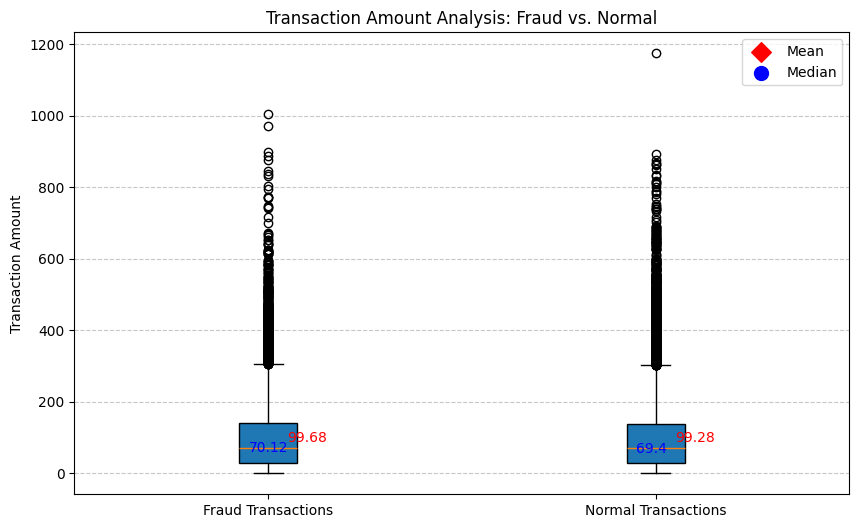

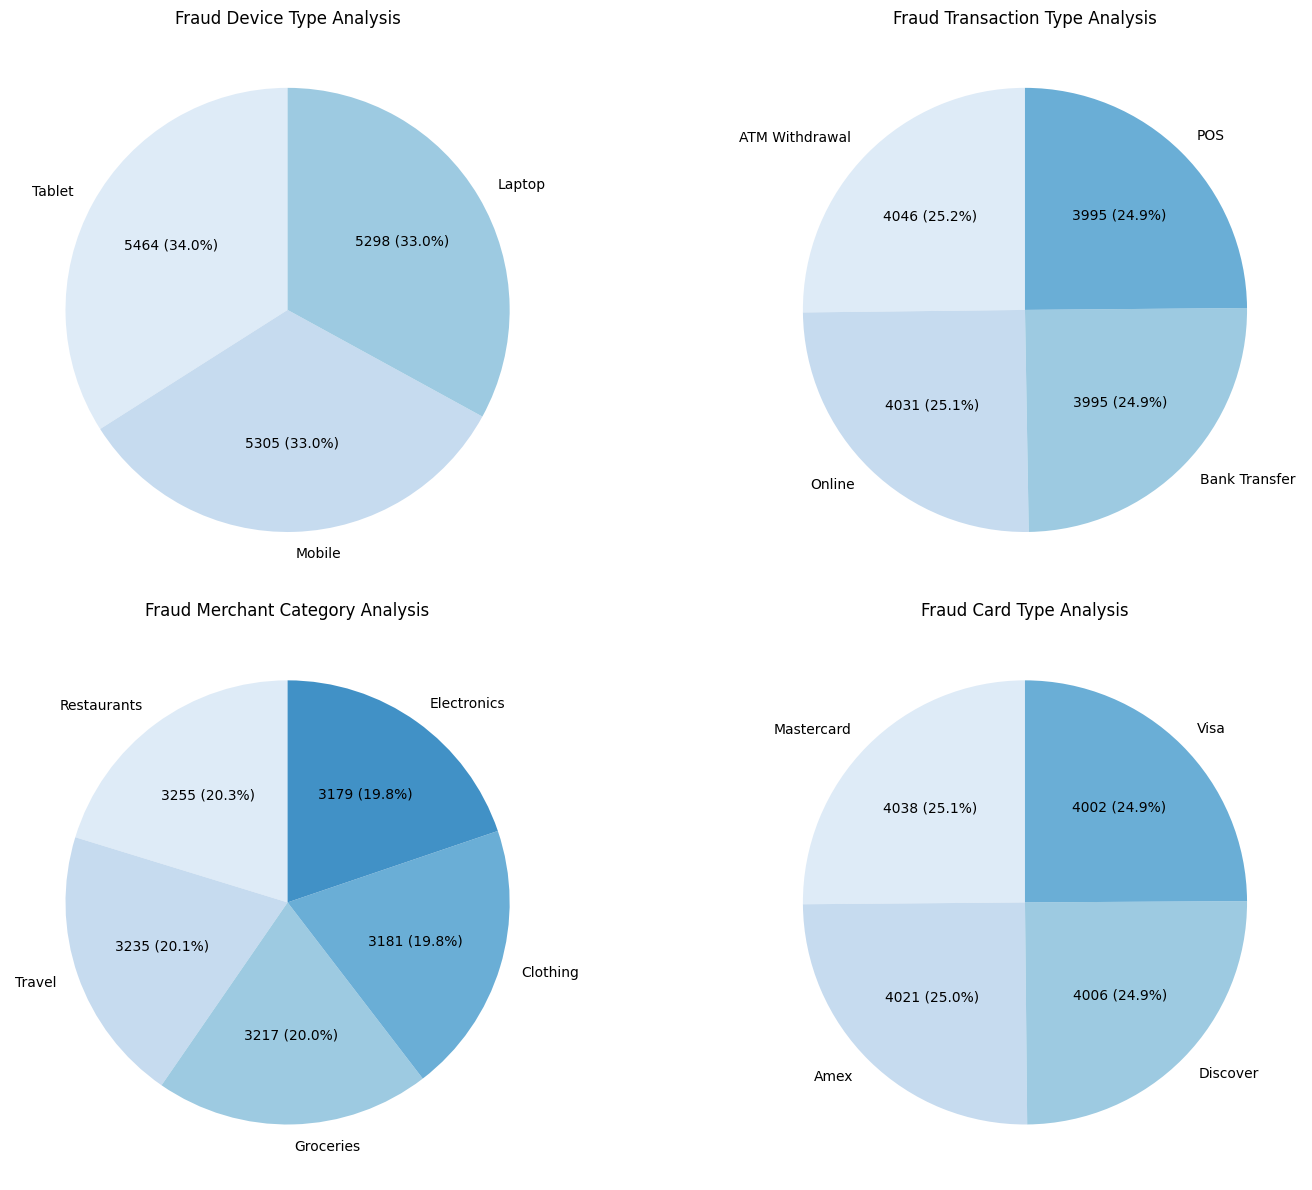

In [6]:
# --------------------Transacation-Related Analysis with data & charts ------------------------
# Transaction amount Analysis
trans_avg = data['Transaction_Amount'].mean().round(2)
print(f"Average transaction value for this data is {trans_avg}")
trans_fraud = fraud_data['Transaction_Amount'].mean().round(2)
print(f"Average fraud transaction value for this data is {trans_fraud}")
no_fruad_avg = no_fraud_data['Transaction_Amount'].mean().round(2)
print(f"Average normal transaction value is {no_fruad_avg}")
#Create the box plot showing the fraud transaction amount and non-fraud transaction value

#-------------------Fraud Device type analysis
print('-------------------Fraud Device type analysis')
fraud_device_distribute = fraud_data['Device_Type'].value_counts()
fraud_device_distribute
# Fraud device distribution with percentage (in one line)
total_fraud_count = fraud_device_distribute.sum()
print("Fraud Device Distribution is " + 
      '; '.join([f"{device}: {count} ({(count/total_fraud_count)*100:.2f}%)" 
                 for device, count in fraud_device_distribute.items()]))
# Total transactions per device type
device_distribution_all = data['Device_Type'].value_counts()
# Fraudulent transactions per device type
fraud_device_distribute = fraud_data['Device_Type'].value_counts()
fraud_percentage = (fraud_device_distribute / device_distribution_all * 100).fillna(0).round(2)
print("Fraud Percentage by Device Type: " + 
      ', '.join([f"{device}: {percent}%" for device, percent in fraud_percentage.items()]))

#-------------------Fraud Transaction type analysis
print('-------------------Fraud Transaction type analysis')
fraud_type_distribute = fraud_data['Transaction_Type'].value_counts()
# Fraud transaction type distribution with percentage (in one line)
total_fraud_type_count = fraud_type_distribute.sum()
print("Fraud trasnction type Distribution is " + 
      '; '.join([f"{device}: {count} ({(count/total_fraud_type_count)*100:.2f}%)" 
                 for device, count in fraud_type_distribute.items()]))
# Total transactions type
trans_type_distribution_all = data['Transaction_Type'].value_counts()
# Fraudulent transactions  type
fraud_trans_type_percentage = (fraud_type_distribute / trans_type_distribution_all * 100).fillna(0).round(2)
print("Fraud Percentage by transaction Type: " + 
      ', '.join([f"{device}: {percent}%" for device, percent in fraud_trans_type_percentage.items()]))

#-------------------Fraud Merchant Category analysis
print('-------------------Fraud Merchant Category analysis')
fraud_Merchant_Category_distribute = fraud_data['Merchant_Category'].value_counts()
# Fraud Merchant Category distribution with percentage (in one line)
total_fraud_Merchant_Category_count = fraud_Merchant_Category_distribute.sum()
print("Fraud Merchant Category Distribution is " + 
      '; '.join([f"{device}: {count} ({(count/total_fraud_Merchant_Category_count)*100:.2f}%)" 
                 for device, count in fraud_Merchant_Category_distribute.items()]))
# Total transactions Merchant Category
trans_Merchant_Category_distribution_all = data['Merchant_Category'].value_counts()
# Fraudulent transactions Merchant Category
fraud_trans_Merchant_Category_percentage = (fraud_Merchant_Category_distribute / trans_Merchant_Category_distribution_all * 100).fillna(0).round(2)
print("Fraud Percentage by Merchant Category: " + 
      ', '.join([f"{device}: {percent}%" for device, percent in fraud_trans_Merchant_Category_percentage.items()]))

#-------------------Fraud Card Type analysis
print('-------------------Fraud Card Type analysis')
fraud_Card_Type_distribute = fraud_data['Card_Type'].value_counts()
# Fraud Card Type distribution with percentage (in one line)
total_fraud_Card_Type_count = fraud_Card_Type_distribute.sum()
print("Fraud Card Type Distribution is " + 
      '; '.join([f"{device}: {count} ({(count/total_fraud_Card_Type_count)*100:.2f}%)" 
                 for device, count in fraud_Card_Type_distribute.items()]))
# Total transactions Card Type
Card_Type_distribution_all = data['Card_Type'].value_counts()
# Fraudulent transactions Card Type
fraud_Card_Type_percentage = (fraud_Card_Type_distribute / Card_Type_distribution_all * 100).fillna(0).round(2)
print("Fraud Percentage by Card Type: " + 
      ', '.join([f"{device}: {percent}%" for device, percent in fraud_Card_Type_percentage.items()]))


import matplotlib.pyplot as plt
import seaborn as sns


fraud_mean = fraud_data['Transaction_Amount'].mean().round(2)
fraud_median = fraud_data['Transaction_Amount'].median().round(2)
normal_mean = no_fraud_data['Transaction_Amount'].mean().round(2)
normal_median = no_fraud_data['Transaction_Amount'].median().round(2)

print(f"Average transaction value: {data['Transaction_Amount'].mean().round(2)}")
print(f"Fraud - Mean: {fraud_mean}, Median: {fraud_median}")
print(f"Normal - Mean: {normal_mean}, Median: {normal_median}")

# Create the box plot for Fraud and Normal transactions
plt.figure(figsize=(10, 6))

# Prepare the data for the box plot
data_to_plot = [
    fraud_data['Transaction_Amount'],   # Fraudulent transactions
    no_fraud_data['Transaction_Amount']   # Normal transactions
]

# Create the box plot with custom labels
box = plt.boxplot(data_to_plot, labels=['Fraud Transactions', 'Normal Transactions'], patch_artist=True)

# Overlay markers for mean and median for each group
# Fraud group (position = 1)
plt.scatter(1, fraud_mean, color='red', marker='D', s=100, label='Mean')
plt.scatter(1, fraud_median, color='blue', marker='o', s=100, label='Median')
plt.text(1.05, fraud_mean, f'{fraud_mean}', va='center', color='red')
plt.text(0.95, fraud_median, f'{fraud_median}', va='center', color='blue')

# Normal group (position = 2)
plt.scatter(2, normal_mean, color='red', marker='D', s=100)
plt.scatter(2, normal_median, color='blue', marker='o', s=100)
plt.text(2.05, normal_mean, f'{normal_mean}', va='center', color='red')
plt.text(1.95, normal_median, f'{normal_median}', va='center', color='blue')

plt.title('Transaction Amount Analysis: Fraud vs. Normal')
plt.ylabel('Transaction Amount')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Create a legend to identify markers
plt.legend()

plt.show()






# Helper function to create autopct label showing count and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{count} ({pct:.1f}%)"
    return my_autopct

# Define the two color palettes
colors_1 = sns.color_palette("Blues", 24)  # for charts with many slices
colors_2 = sns.color_palette("Blues", 7)   # for charts with fewer slices

# Compute counts for each analysis from the fraud_data DataFrame
fraud_device_counts = fraud_data['Device_Type'].value_counts()
fraud_transaction_counts = fraud_data['Transaction_Type'].value_counts()
fraud_merchant_counts = fraud_data['Merchant_Category'].value_counts()
fraud_card_counts = fraud_data['Card_Type'].value_counts()

# Create a figure with a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# A helper function to choose color palette based on number of slices
def get_colors(counts):
    n = len(counts)
    # Use colors_2 if number of slices is less or equal to 7, else colors_1
    return colors_2[:n] if n <= 7 else colors_1[:n]

# ---------------- Fraud Device Type Analysis ----------------
axes[0, 0].pie(
    fraud_device_counts.values,
    labels=fraud_device_counts.index,
    autopct=make_autopct(fraud_device_counts.values),
    colors=get_colors(fraud_device_counts),
    startangle=90
)
axes[0, 0].set_title('Fraud Device Type Analysis')

# ---------------- Fraud Transaction Type Analysis ----------------
axes[0, 1].pie(
    fraud_transaction_counts.values,
    labels=fraud_transaction_counts.index,
    autopct=make_autopct(fraud_transaction_counts.values),
    colors=get_colors(fraud_transaction_counts),
    startangle=90
)
axes[0, 1].set_title('Fraud Transaction Type Analysis')

# ---------------- Fraud Merchant Category Analysis ----------------
axes[1, 0].pie(
    fraud_merchant_counts.values,
    labels=fraud_merchant_counts.index,
    autopct=make_autopct(fraud_merchant_counts.values),
    colors=get_colors(fraud_merchant_counts),
    startangle=90
)
axes[1, 0].set_title('Fraud Merchant Category Analysis')

# ---------------- Fraud Card Type Analysis ----------------
axes[1, 1].pie(
    fraud_card_counts.values,
    labels=fraud_card_counts.index,
    autopct=make_autopct(fraud_card_counts.values),
    colors=get_colors(fraud_card_counts),
    startangle=90
)
axes[1, 1].set_title('Fraud Card Type Analysis')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


Total transactions: 50000
Fraudulent transactions: 16067 (32.13%)


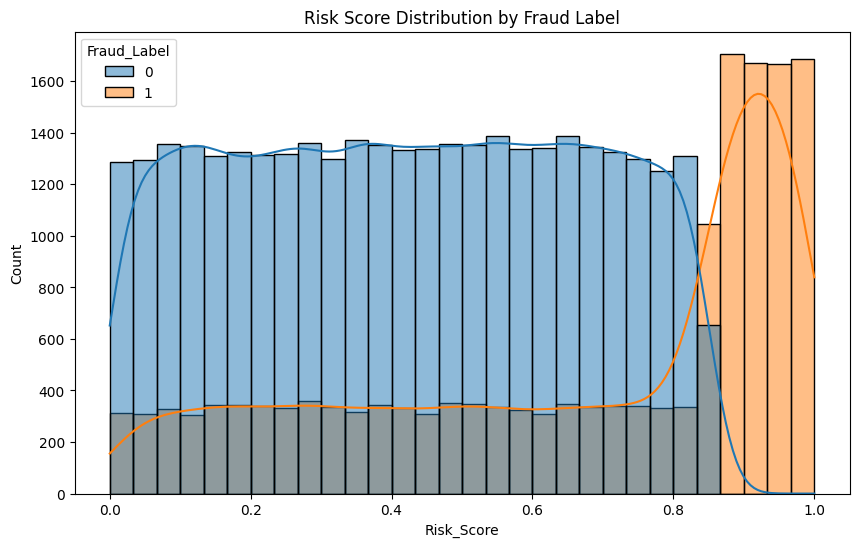

C:\Users\Administrator\AppData\Local\Temp\ipykernel_19232\2461661274.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby('Risk_Level')['Fraud_Label'].agg(['count', 'sum'])


            count   sum  Fraud Rate (%)
Risk_Level                             
Low         12289  2425       19.733095
Medium      12615  2529       20.047562
High        12619  2495       19.771773
Critical    12477  8618       69.071091
✅ Best Threshold: 0.85
   Precision: 1.00
   Recall:    0.47
   F1 Score:  0.64


In [45]:
# --------------------- Risk Score Analysis -------------------------------------------
total = len(data)
frauds = data['Fraud_Label'].sum()
fraud_rate = (frauds / total) * 100
print(f"Total transactions: {total}")
print(f"Fraudulent transactions: {frauds} ({fraud_rate:.2f}%)")
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Risk_Score', hue='Fraud_Label', bins=30, kde=True)
plt.title("Risk Score Distribution by Fraud Label")
plt.show()
bins = [0, 0.25, 0.5, 0.75, 1.0]
labels = ['Low', 'Medium', 'High', 'Critical']
data['Risk_Level'] = pd.cut(data['Risk_Score'], bins=bins, labels=labels)

summary = data.groupby('Risk_Level')['Fraud_Label'].agg(['count', 'sum'])
summary['Fraud Rate (%)'] = (summary['sum'] / summary['count']) * 100
print(summary)

from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

thresholds = np.arange(0, 1.01, 0.01)
f1s, precisions, recalls = [], [], []

for t in thresholds:
    preds = (data['Risk_Score'] >= t).astype(int)
    f1s.append(f1_score(data['Fraud_Label'], preds))
    precisions.append(precision_score(data['Fraud_Label'], preds, zero_division=0))
    recalls.append(recall_score(data['Fraud_Label'], preds))

best_index = np.argmax(f1s)
best_threshold = thresholds[best_index]

print(f"✅ Best Threshold: {best_threshold:.2f}")
print(f"   Precision: {precisions[best_index]:.2f}")
print(f"   Recall:    {recalls[best_index]:.2f}")
print(f"   F1 Score:  {f1s[best_index]:.2f}")

summary_data = []

for t in [0.7, 0.8, 0.85]:
    preds = (data['Risk_Score'] >= t).astype(int)
    precision = precision_score(data['Fraud_Label'], preds, zero_division=0)
    recall = recall_score(data['Fraud_Label'], preds)
    f1 = f1_score(data['Fraud_Label'], preds)
    flagged = preds.sum()
    frauds_found = data.loc[preds == 1, 'Fraud_Label'].sum()
    fraud_rate = (frauds_found / flagged * 100) if flagged > 0 else 0
    summary_data.append([t, precision, recall, f1, fraud_rate, flagged])

pd.DataFrame(summary_data, columns=['Threshold', 'Precision', 'Recall', 'F1', 'Fraud Rate (%)', 'Flagged Txns'])
data['Predicted_Fraud'] = (data['Risk_Score'] >= best_threshold).astype(int)

false_positives = data[(data['Predicted_Fraud'] == 1) & (data['Fraud_Label'] == 0)]
false_negatives = data[(data['Predicted_Fraud'] == 0) & (data['Fraud_Label'] == 1)]
high_risk = data[data['Risk_Score'] >= best_threshold]
# high_risk.to_csv("flagged_transactions.csv", index=False)


                              Risk_Score
Risk_Score                      1.000000
Fraud_Label                     0.385810
Transaction_Amount              0.005606
Avg_Transaction_Amount_7d       0.004977
Failed_Transaction_Count_7d     0.000814
Card_Age                       -0.001385
Previous_Fraudulent_Activity   -0.002815
IP_Address_Flag                -0.004064
Account_Balance                -0.005262
Daily_Transaction_Count        -0.007572


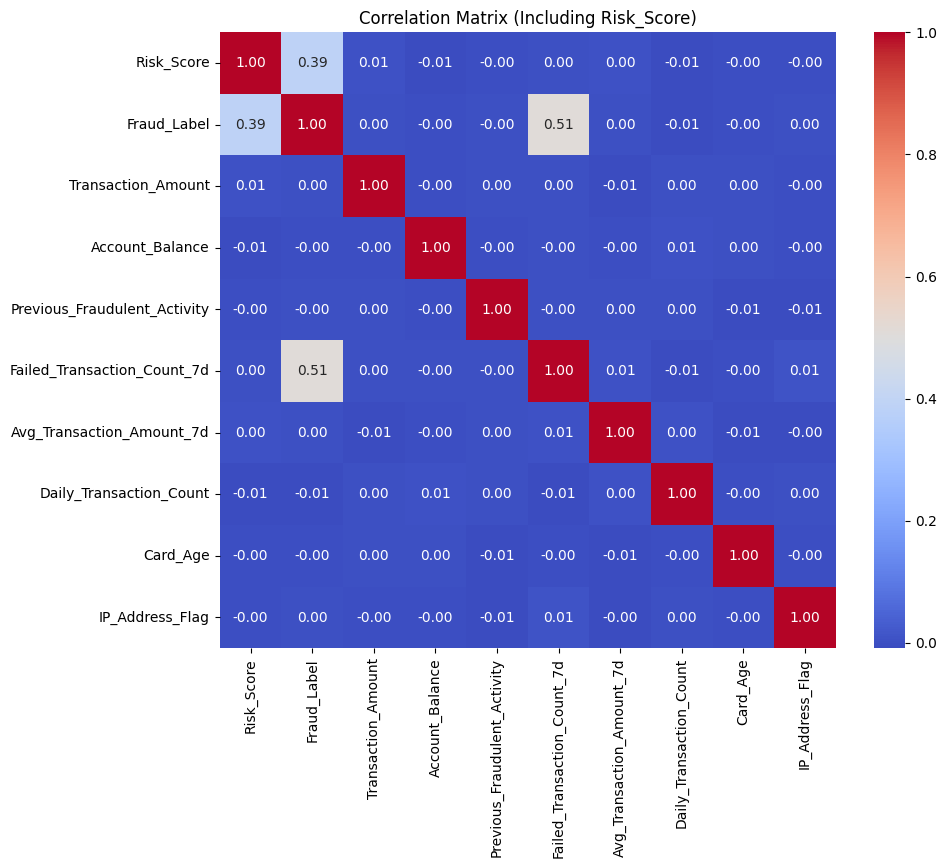

In [46]:
# ---------------------- Risk Scaore Correlation Heatmap---------------------------------
# Select relevant columns
features_to_corr = [
    'Risk_Score',
    'Fraud_Label',
    'Transaction_Amount',
    'Account_Balance',
    'Previous_Fraudulent_Activity',
    'Failed_Transaction_Count_7d',
    'Avg_Transaction_Amount_7d',
    'Daily_Transaction_Count',
    'Card_Age',
    'IP_Address_Flag'
]

# Create correlation matrix
corr_matrix = data[features_to_corr].corr()

# Display correlation with Risk_Score
risk_corr = corr_matrix[['Risk_Score']].sort_values(by='Risk_Score', ascending=False)
print(risk_corr)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix (Including Risk_Score)")
plt.show()


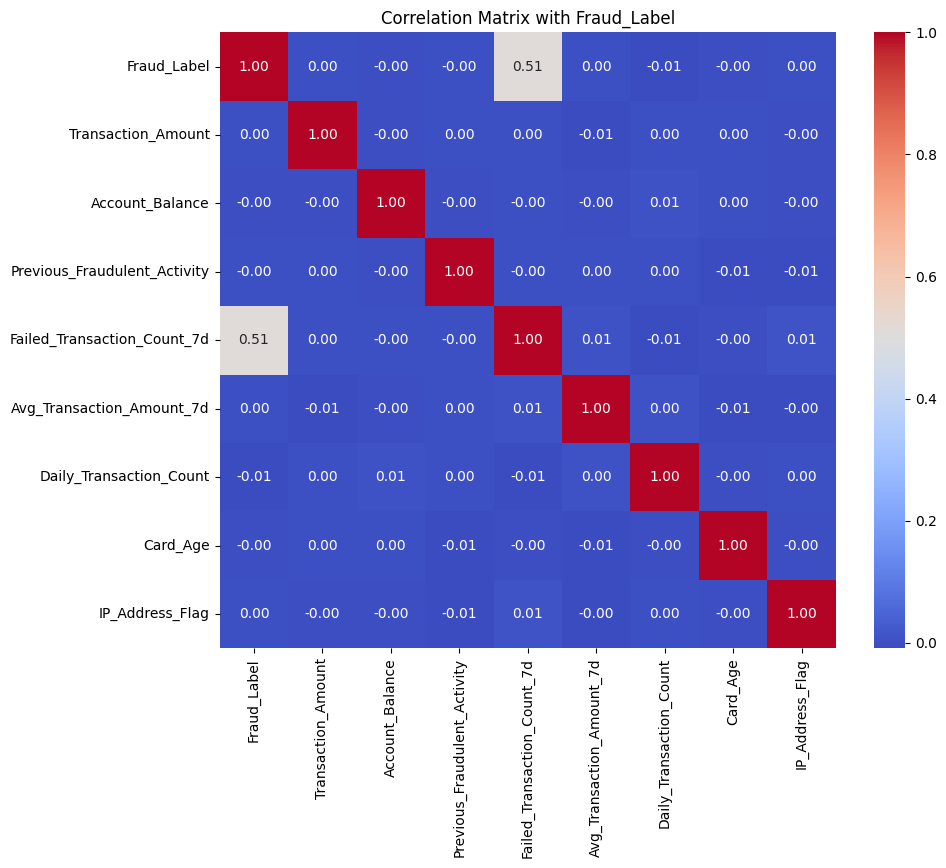

In [ ]:
# --------------------- Correlation matrix for Fraud_Label ---------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Select meaningful features for correlation with Fraud_Label
corr_features = [
    'Fraud_Label',
    'Transaction_Amount',
    'Account_Balance',
    'Previous_Fraudulent_Activity',
    'Failed_Transaction_Count_7d',
    'Avg_Transaction_Amount_7d',
    'Daily_Transaction_Count',
    'Card_Age',
    'IP_Address_Flag'
]

# Compute correlation matrix
fraud_corr_matrix = data[corr_features].corr()

# Visualize correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(fraud_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix with Fraud_Label")
plt.show()


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:18:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUC Score: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6787
           1       1.00      1.00      1.00      3213

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



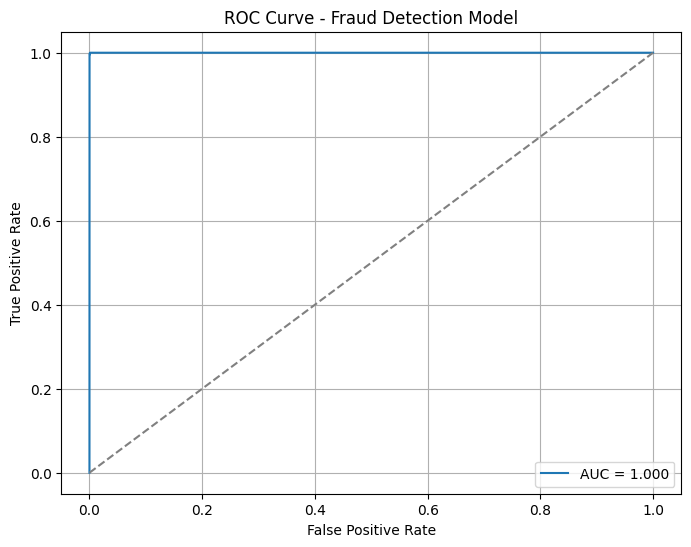

Sample risk score results:
       Transaction_Amount  Transaction_Type  Account_Balance  Device_Type  \
12508              133.71                 1          5464.13            2   
14150               27.06                 3         33723.46            0   
41625               32.60                 1         65511.01            2   
1991               364.34                 2         87825.46            1   
7320               240.65                 2          5283.10            0   

       Location  Merchant_Category  IP_Address_Flag  \
12508         1                  1                0   
14150         1                  0                0   
41625         4                  4                0   
1991          0                  3                0   
7320          2                  4                0   

       Previous_Fraudulent_Activity  Daily_Transaction_Count  \
12508                             0                       11   
14150                             0                

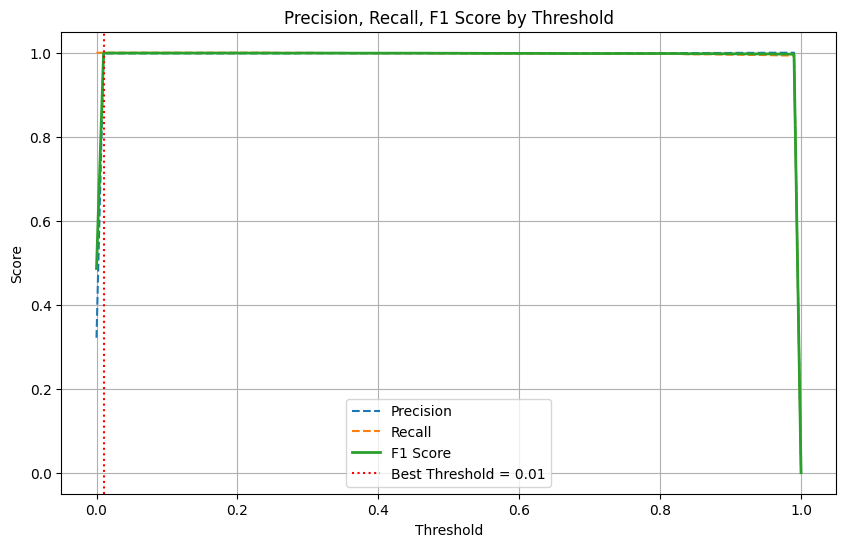

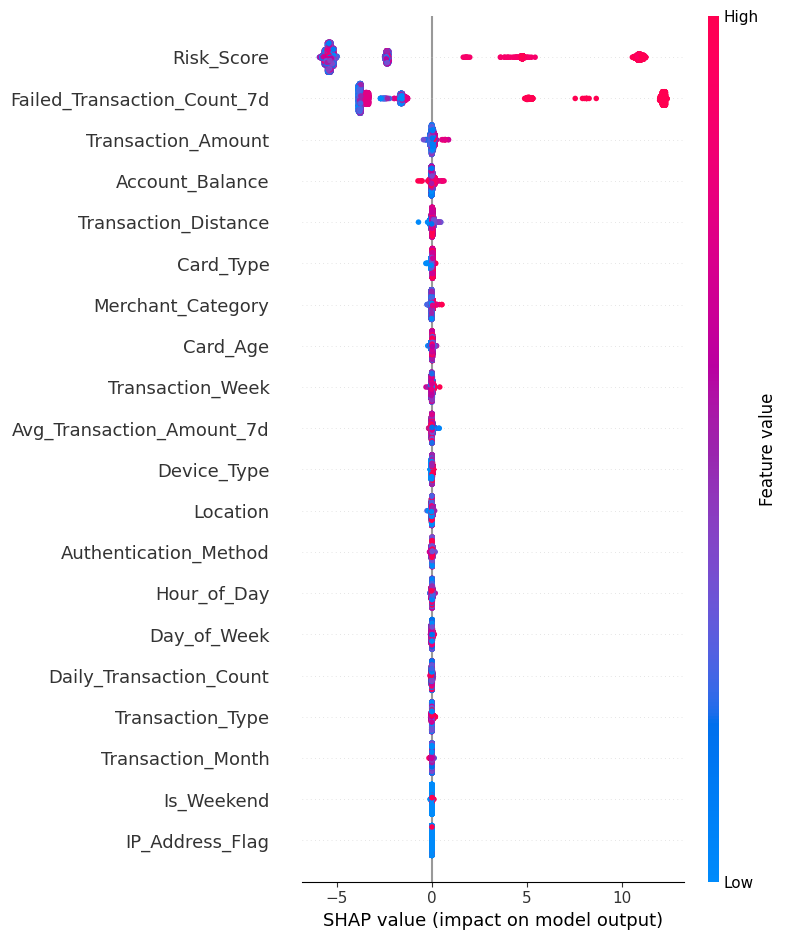

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import (
    roc_auc_score, classification_report, roc_curve,
    precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import shap


data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')

# --- Copy to a new DataFrame for modeling (non-destructive) ---
data_model = data.copy()

# --- Extract time-based features ---
data_model['Transaction_Month'] = data_model['Timestamp'].dt.month
data_model['Transaction_Week'] = data_model['Timestamp'].dt.isocalendar().week.astype(int)
data_model['Day_of_Week'] = data_model['Timestamp'].dt.day_name()
data_model['Hour_of_Day'] = data_model['Timestamp'].dt.hour
data_model['Is_Weekend'] = data_model['Timestamp'].dt.dayofweek.isin([5, 6]).astype(int)

# --- Drop non-modeling identifiers ---
data_model = data_model.drop(['Transaction_ID', 'User_ID', 'Timestamp'], axis=1)

# --- Encode categorical columns ---
categorical_cols = ['Transaction_Type', 'Device_Type', 'Location',
                    'Merchant_Category', 'Card_Type', 'Authentication_Method',
                    'Day_of_Week']

for col in categorical_cols:
    data_model[col] = LabelEncoder().fit_transform(data_model[col])

# -----------------------------------------------
# 2. Split Data into Features and Target, Train/Test
# -----------------------------------------------
X = data_model.drop('Fraud_Label', axis=1)
y = data_model['Fraud_Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------------------------
# 3. Model Training with XGBoost
# -----------------------------------------------
model = xgb.XGBClassifier(n_estimators=200, max_depth=6, 
                          learning_rate=0.05, random_state=42,
                          use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# -----------------------------------------------
# 4. Model Evaluation: ROC, Classification Report, Risk Score
# -----------------------------------------------
# Predict probabilities and class labels
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

# Calculate AUC
auc = roc_auc_score(y_test, y_proba)
print(f"AUC Score: {auc:.3f}")

# Classification Report
print(classification_report(y_test, y_pred))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Fraud Detection Model")
plt.legend()
plt.grid(True)
plt.show()

# Append risk scores to the test set for further analysis
results = X_test.copy()
results['Actual_Fraud_Label'] = y_test
results['New_Risk_Score'] = y_proba
print("Sample risk score results:")
print(results.head())

# -----------------------------------------------
# 5. Threshold Analysis: Precision, Recall, F1 Score vs. Threshold
# -----------------------------------------------
thresholds = np.arange(0, 1.01, 0.01)
precision_list, recall_list, f1_list = [], [], []

for thresh in thresholds:
    preds = (y_proba >= thresh).astype(int)
    precision_list.append(precision_score(y_test, preds, zero_division=0))
    recall_list.append(recall_score(y_test, preds))
    f1_list.append(f1_score(y_test, preds))

# Find best threshold based on F1 Score
best_index = np.argmax(f1_list)
best_threshold = thresholds[best_index]
print(f"Best threshold: {best_threshold:.2f} (F1: {f1_list[best_index]:.3f})")

# Plot metrics vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label="Precision", linestyle='--')
plt.plot(thresholds, recall_list, label="Recall", linestyle='--')
plt.plot(thresholds, f1_list, label="F1 Score", linewidth=2)
plt.axvline(best_threshold, color='red', linestyle=':', label=f"Best Threshold = {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 Score by Threshold")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------------------------
# 6. Explainability: SHAP Summary Plot
# -----------------------------------------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


In [24]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb

# 1. Define your model (if not already defined)
model = xgb.XGBClassifier(
    n_estimators=200, 
    max_depth=6, 
    learning_rate=0.05, 
    random_state=42,
    use_label_encoder=False, 
    eval_metric='logloss'
)

# 2. Setup a stratified K-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Evaluate model performance across folds using AUC
auc_scores = cross_val_score(
    model, 
    X, 
    y, 
    scoring='roc_auc', 
    cv=kfold, 
    n_jobs=-1
)

# 4. Print out the fold results
print("Cross-Validation AUC Scores:", auc_scores)
print(f"Mean AUC: {auc_scores.mean():.3f}")
print(f"Standard Deviation of AUC: {auc_scores.std():.3f}")


Cross-Validation AUC Scores: [0.9999945  0.99999514 0.99999651 0.99999743 0.99999725]
Mean AUC: 1.000
Standard Deviation of AUC: 0.000


In [26]:
!pip install nbformat


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
